# Libraries and DB Connection

In [ ]:
import os
import sys
from dotenv import load_dotenv
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import pipeline
import statsmodels.api as sm
from tqdm import tqdm
from scipy import stats

# Securely load credentials

# Get the current working directory of the notebooks
current_dir = os.getcwd()

# Navigate up one level to the project root to find .env.cred
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))
dotenv_path = os.path.join(project_root, '.env.cred')

# Load the variables into the environment
loaded = load_dotenv(dotenv_path)

# config DB connection

# Access variables
DB_CONFIG = {
    'host':     os.getenv('DB_HOST'),
    'port':     os.getenv('DB_PORT', '3306'), 
    'user':     os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'database': os.getenv('DB_NAME'),
}

# Create the Engine
connection_string = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

def run_query(query, params=None):
    return pd.read_sql(query, engine, params=params)

# **Attendance Growth**

## Monthly Trends

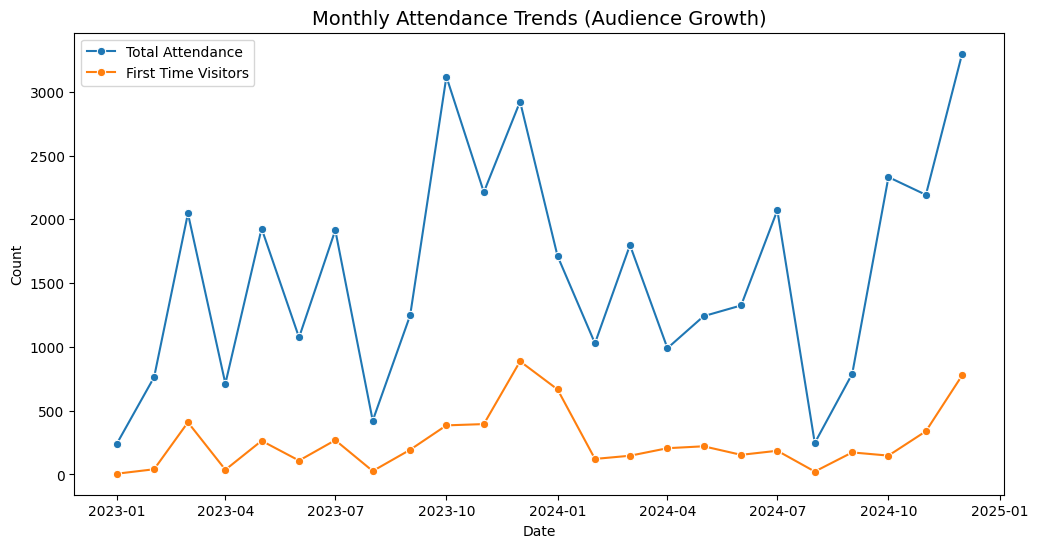

In [13]:
# LOAD: Attendance time series
sql_monthly_trends = """
SELECT
    YEAR(month_year)  AS year,
    MONTH(month_year) AS month,
    DATE_FORMAT(month_year, '%%Y-%%m-01') AS full_date, 
    total_attendance,
    total_first_time_visitors
FROM attendance
WHERE month_year < '2025-01-01'          
ORDER BY year, month;
"""

df_trends = run_query(sql_monthly_trends)
df_trends['full_date'] = pd.to_datetime(df_trends['full_date'])

# VISUALIZATION: Total Attendance vs First Timers
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_trends, x='full_date', y='total_attendance', label='Total Attendance', marker='o')
sns.lineplot(data=df_trends, x='full_date', y='total_first_time_visitors', label='First Time Visitors', marker='o')
plt.title('Monthly Attendance Trends (Audience Growth)', fontsize=14)
plt.ylabel('Count')
plt.xlabel('Date')
plt.legend()
plt.show()


## Attendance Seasonality

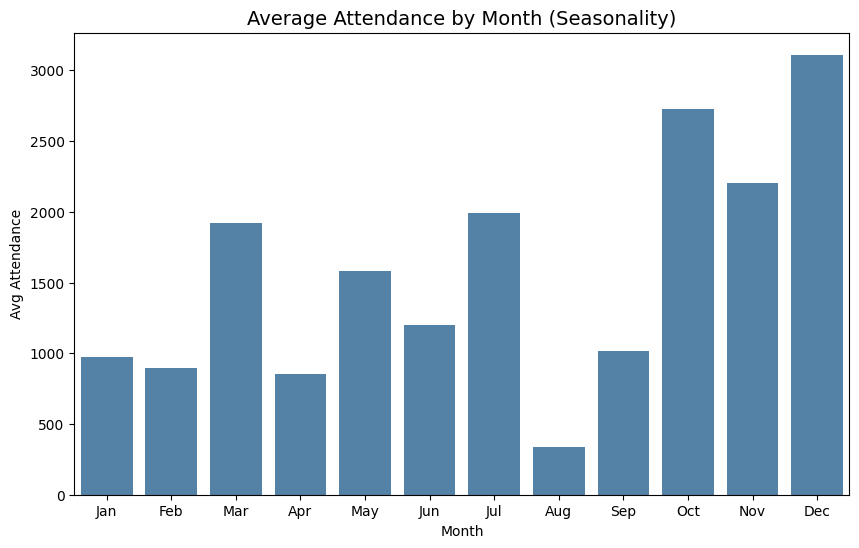

In [14]:
# LOAD: Attendance averaged across months
sql_seasonality = """
SELECT
    MONTH(month_year) AS month_num,
    DATE_FORMAT(month_year, '%%b') AS month_name,
    AVG(total_attendance) AS avg_monthly_attendance,
    AVG(total_first_time_visitors) AS avg_monthly_first_time_visitors,
    AVG(total_first_time_visitors / NULLIF(total_attendance, 0)) AS avg_first_time_ratio
FROM attendance
WHERE month_year < '2025-01-01'
GROUP BY month_num, month_name
ORDER BY month_num;
"""

df_seasonality = run_query(sql_seasonality)

# VISUALIZATION: Seasonality Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_seasonality, x='month_name', y='avg_monthly_attendance', color='steelblue')
plt.title('Average Attendance by Month (Seasonality)', fontsize=14)
plt.ylabel('Avg Attendance')
plt.xlabel('Month')
plt.show()


## Attendance Retention Metrics

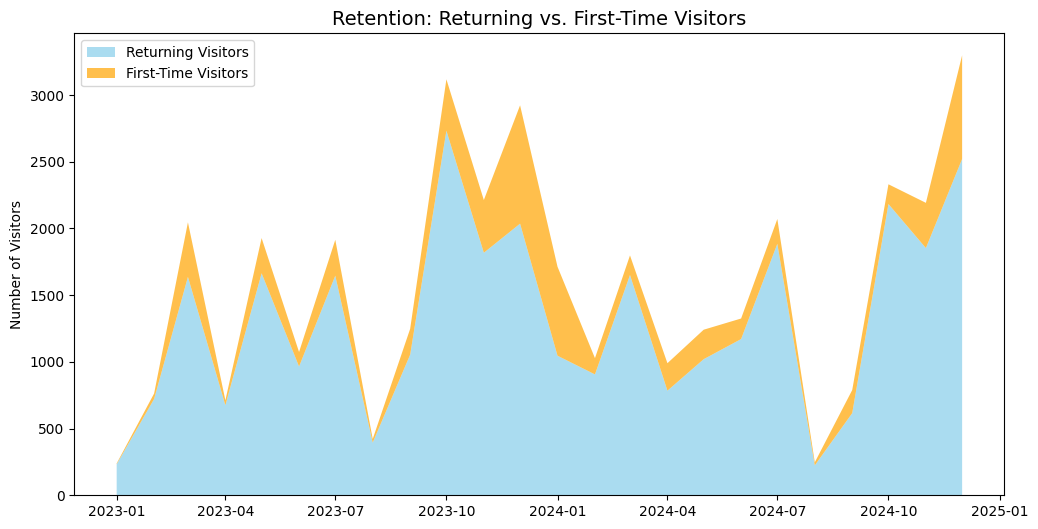

In [15]:
# LOAD: attendance retention metrics
sql_retention = """
SELECT
    DATE_FORMAT(month_year, '%%Y-%%m-01') AS full_date,
    total_attendance,
    total_first_time_visitors,
    (total_attendance - total_first_time_visitors) AS returning_visitors,
    ROUND(total_first_time_visitors / NULLIF(total_attendance, 0), 3) AS first_time_ratio,
    ROUND((total_attendance - total_first_time_visitors) / NULLIF(total_attendance, 0), 3) AS returning_ratio
FROM attendance
WHERE month_year BETWEEN '2023-01-01' AND '2024-12-31'
  AND total_attendance > 0
ORDER BY full_date;
"""

df_retention = run_query(sql_retention)
df_retention['full_date'] = pd.to_datetime(df_retention['full_date'])

# VISUALIZATION: Stacked Area Chart for Retention
plt.figure(figsize=(12, 6))
plt.stackplot(df_retention['full_date'], 
              df_retention['returning_visitors'], 
              df_retention['total_first_time_visitors'], 
              labels=['Returning Visitors', 'First-Time Visitors'],
              colors=['skyblue', 'orange'], alpha=0.7)
plt.legend(loc='upper left')
plt.title('Retention: Returning vs. First-Time Visitors', fontsize=14)
plt.ylabel('Number of Visitors')
plt.show()

## Correlation between First Time Visitors and Total Attendance

--- Statistical Analysis ---
Correlation (r): 0.7803
P-Value:         6.8833e-06
Result:           Statistically Significant


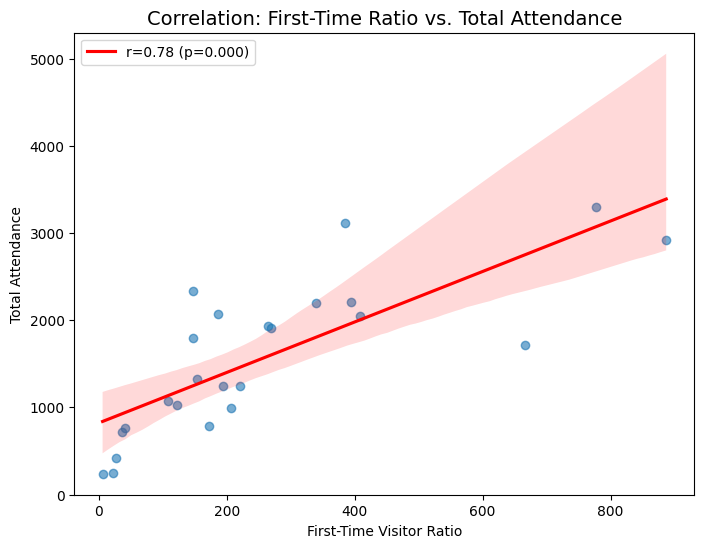

In [16]:
# Correlation with Significance Test

# 1. Calculate Pearson r and p-value
r, p_value = stats.pearsonr(df_trends['total_first_time_visitors'], df_trends['total_attendance'])

# 2. Interpretation
sig_label = " Statistically Significant" if p_value < 0.05 else "Not Significant"

print(f"--- Statistical Analysis ---")
print(f"Correlation (r): {r:.4f}")
print(f"P-Value:         {p_value:.4e}")
print(f"Result:          {sig_label}")

# 3. Visualization
plt.figure(figsize=(8, 6))
sns.regplot(data=df_trends, x='total_first_time_visitors', y='total_attendance', 
            line_kws={"color": "red", "label": f"r={r:.2f} (p={p_value:.3f})"}, 
            scatter_kws={"alpha": 0.6})

plt.title(f'Correlation: First-Time Ratio vs. Total Attendance', fontsize=14)
plt.xlabel('First-Time Visitor Ratio')
plt.ylabel('Total Attendance')
plt.legend()
plt.show()

## Correlation between Returing Attendees and donations

--- Statistical Analysis ---
Correlation (r): 0.2130
P-Value:         3.1776e-01
Result:          Not Significant


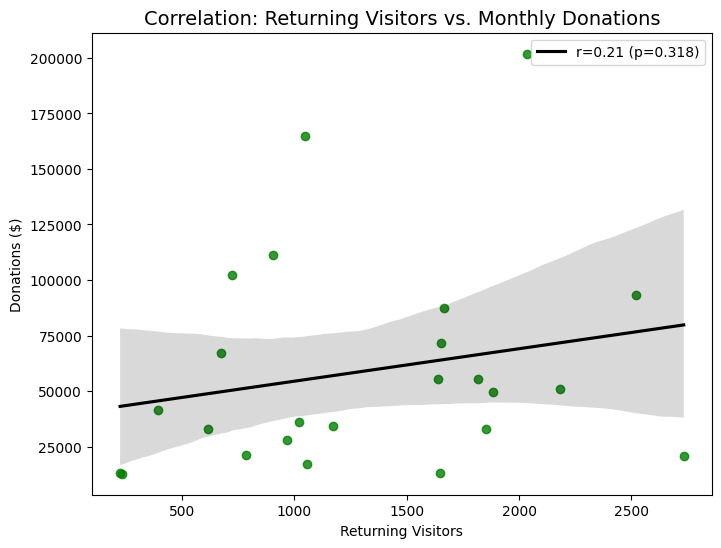

In [17]:
# 1. load data for this correlation
sql_donations_corr = """
SELECT
    a.month_year,
    (a.total_attendance - a.total_first_time_visitors) AS returning_visitors,
    COALESCE(d.monthly_donations, 0) AS monthly_donations
FROM attendance AS a
LEFT JOIN (
    SELECT
        DATE_FORMAT(date, '%%Y-%%m-01') AS month_key,
        SUM(donation_received) AS monthly_donations
    FROM donations
    GROUP BY month_key
) AS d
    ON DATE_FORMAT(a.month_year, '%%Y-%%m-01') = d.month_key
WHERE a.month_year < '2025-01-01'
ORDER BY a.month_year;
"""
df_finance_corr = run_query(sql_donations_corr)

# 2. Calculate r and p-value
r_fin, p_fin = stats.pearsonr(df_finance_corr['returning_visitors'], df_finance_corr['monthly_donations'])

# 2. Interpretation
sig_label_fin = "Statistically Significant" if p_fin < 0.05 else "Not Significant"

print(f"--- Statistical Analysis ---")
print(f"Correlation (r): {r_fin:.4f}")
print(f"P-Value:         {p_fin:.4e}")
print(f"Result:          {sig_label_fin}")

# 3. Visualization
plt.figure(figsize=(8, 6))
sns.regplot(data=df_finance_corr, x='returning_visitors', y='monthly_donations', 
            color='green', 
            line_kws={"color": "black", "label": f"r={r_fin:.2f} (p={p_fin:.3f})"})

plt.title('Correlation: Returning Visitors vs. Monthly Donations', fontsize=14)
plt.xlabel('Returning Visitors')
plt.ylabel('Donations ($)')
plt.legend()
plt.show()

# **Event Performance**

## Fetch Raw Data into Dataframes

In [18]:
# Fetch Raw Data

# Events Table (Dates & Times)
sql_events_raw = """
SELECT 
    event_id,
    event_title,
    date AS event_date,
    start_time,
    end_time,
    DATE_FORMAT(date, '%%Y-%%m-01') AS month_key
FROM events;
"""

# Monthly Attendance (For calculating average per event)
sql_monthly_att = """
SELECT 
    DATE_FORMAT(month_year, '%%Y-%%m-01') AS month_key,
    total_attendance
FROM attendance;
"""

# Ticket Prices (Averages per event)
sql_ticket_prices = """
SELECT 
    event_id,
    AVG(ticket_prices) AS avg_ticket_price
FROM tickets
WHERE ticket_prices IS NOT NULL 
  AND event_title NOT LIKE '%%ticket protection%%'
GROUP BY event_id;
"""

# Load into DataFrames
df_events = run_query(sql_events_raw)
df_att_monthly = run_query(sql_monthly_att)
df_prices = run_query(sql_ticket_prices)

print("Data Loaded.")
print(f"Events: {len(df_events)}, Monthly Stats: {len(df_att_monthly)}, Prices: {len(df_prices)}")

Data Loaded.
Events: 206, Monthly Stats: 26, Prices: 132


## Feature Engineering

In [19]:
# Categorize event titles into event types using NLP
# Calcualte evnets duration

# NLP Categorization 
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
candidate_labels = [
    "Theatre Play", 
    "Musical", 
    "Music Concert", 
    "Film Screening",
    "Comedy Show", 
    "Fundraiser / Gala",
    "Workshop / Class"
]

def categorize_with_nlp(title):
    try:
        result = classifier(title, candidate_labels, multi_label=False)
        return result['labels'][0]
    except:
        return "General/Other"

tqdm.pandas()
print("Categorizing events using AI...")
df_events['genre'] = df_events['event_title'].progress_apply(categorize_with_nlp)

# Duration Calculation
def calculate_duration_hhmm(row):
    try:
        # Convert inputs to strings and ensure 4 digits
        start_str = str(int(row['start_time'])).zfill(4)
        end_str = str(int(row['end_time'])).zfill(4)
        
        # Parse Hours and Minutes
        start_hr, start_min = int(start_str[:2]), int(start_str[2:])
        end_hr, end_min = int(end_str[:2]), int(end_str[2:])
        
        # Convert both to "minutes from midnight"
        start_total_mins = (start_hr * 60) + start_min
        end_total_mins = (end_hr * 60) + end_min
        
        # Calculate difference
        duration = end_total_mins - start_total_mins
        
        # Handle midnight crossing (e.g., 2300 to 0100)
        if duration < 0:
            duration += 1440  # Add 24 hours in minutes
            
        return duration
    except (ValueError, TypeError):
        return 0

# Apply the function
df_events['duration_mins'] = df_events.apply(calculate_duration_hhmm, axis=1)

# Check the results
print("Duration calculation complete.")
print(df_events[['event_title','genre','duration_mins']].head(5))

Device set to use mps:0


Categorizing events using AI...


100%|██████████| 206/206 [02:42<00:00,  1.27it/s]


Duration calculation complete.
                                         event_title           genre  \
0               “Walla Walla”: A Short Film Premiere  Film Screening   
1                         Power House Movie: Sam Now  Film Screening   
2                                    Youtopia (film)  Film Screening   
3                                 Scout Durwood Live     Comedy Show   
4  Power House Movie: An Evening of Ukrainian Shorts  Film Screening   

   duration_mins  
0            120  
1            180  
2            180  
3            180  
4            120  


## Merging the Dataframes

In [20]:
# 1. Count how many events happened in each month
events_per_month = df_events.groupby('month_key').size().reset_index(name='num_events')

# 2. Merge monthly attendance with the event counts
df_monthly_metrics = pd.merge(df_att_monthly, events_per_month, on='month_key', how='inner')

# 3. Calculate "Estimated Attendance Per Event"
# (Total Monthly Attendance / Number of Events in that Month)
df_monthly_metrics['avg_att_per_event'] = df_monthly_metrics['total_attendance'] / df_monthly_metrics['num_events']

# 4. Merge everything back to the main Events dataframe
# Note: We merge ONTO df_events, preserving the 'genre' column created by the AI
df_final_events = pd.merge(df_events, df_monthly_metrics[['month_key', 'avg_att_per_event']], on='month_key', how='left')

# 5. Merge ticket prices
df_final_events = pd.merge(df_final_events, df_prices, on='event_id', how='left')

# 6. Clean up (Drop rows where we can't calculate attendance)
df_final_events = df_final_events.dropna(subset=['avg_att_per_event'])

df_final_events[['event_title', 'genre', 'avg_att_per_event']].head()

,event_title,genre,avg_att_per_event
0,“Walla Walla”: A Short Film Premiere,Film Screening,79.666667
1,Power House Movie: Sam Now,Film Screening,79.666667
2,Youtopia (film),Film Screening,381.500000
3,Scout Durwood Live,Comedy Show,381.500000
4,Power House Movie: An Evening of Ukrainian Shorts,Film Screening,136.400000


## Visualization

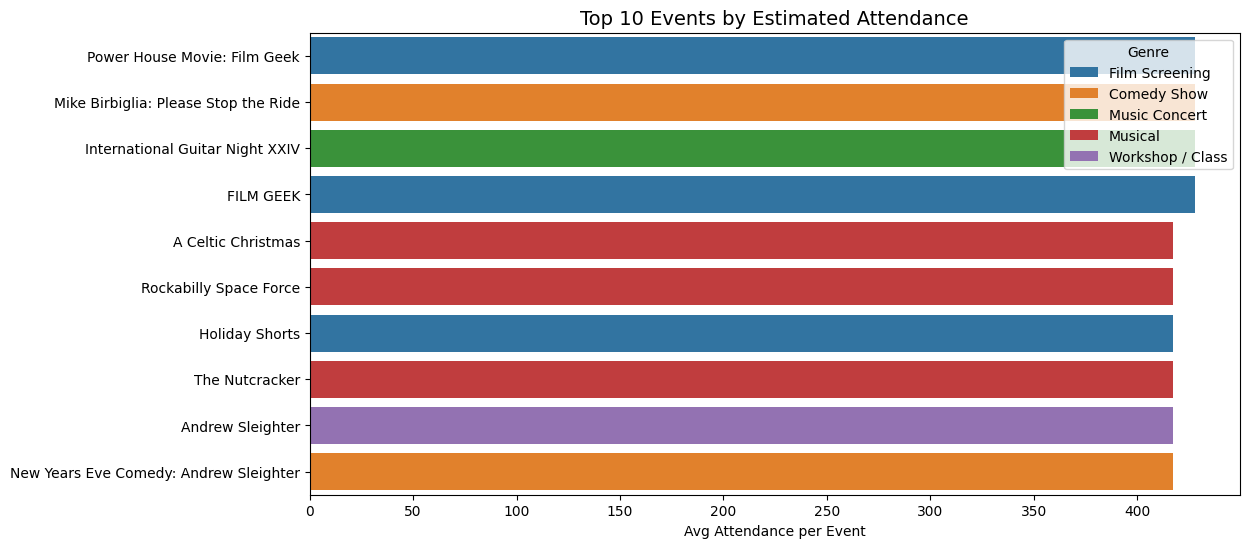

In [21]:
# ==========================================
# Cell 4: Visualizing Performance
# ==========================================

# 1. Top 10 Events by Estimated Attendance
top_10 = df_final_events.sort_values('avg_att_per_event', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10, y='event_title', x='avg_att_per_event', hue='genre', dodge=False)
plt.title('Top 10 Events by Estimated Attendance', fontsize=14)
plt.xlabel('Avg Attendance per Event')
plt.ylabel('')
plt.legend(title='Genre')
plt.show()

/var/folders/p6/7rqrp6w17vl0ny3w4x6480br0000gn/T/ipykernel_93105/3365169465.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final_events, x='genre', y='avg_att_per_event', palette='Set2')


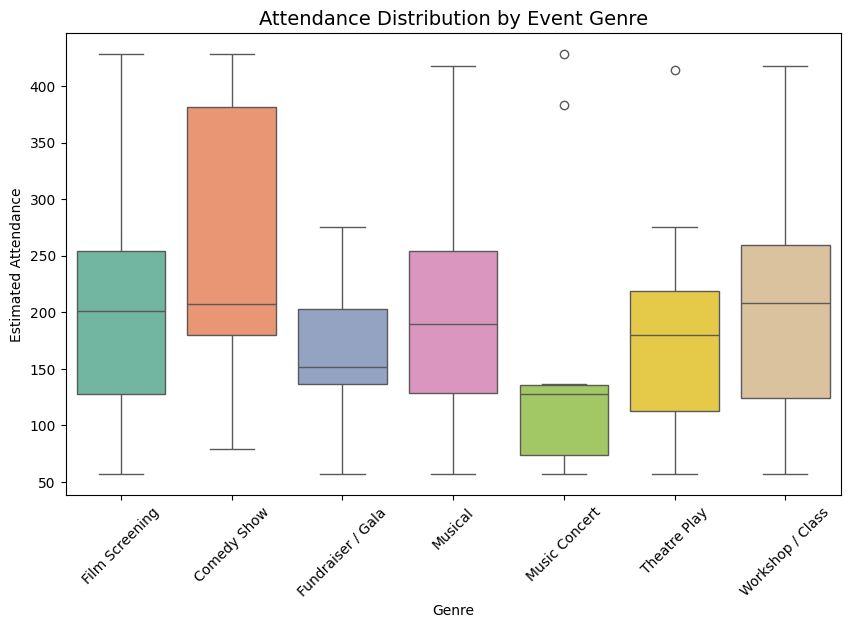

In [22]:

# 2. Performance by Genre (Boxplot)
# It shows which categories (Films, Plays, etc.) bring in the most people on average.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final_events, x='genre', y='avg_att_per_event', palette='Set2')
plt.title('Attendance Distribution by Event Genre', fontsize=14)
plt.ylabel('Estimated Attendance')
plt.xlabel('Genre')
plt.xticks(rotation=45) # Rotate labels so they don't overlap
plt.show()

In [30]:
# Question: Is the difference in attendance between genres real or random?

from scipy.stats import f_oneway

# 1. Prepare groups for the test
groups = []
genres = df_final_events['genre'].unique()

for g in genres:
    values = df_final_events[df_final_events['genre'] == g]['avg_att_per_event']
    groups.append(values)

# 2. Run ANOVA
stat, p_val_anova = f_oneway(*groups)

print("One-Way ANOVA Test")
print(f"F-Statistic: {stat:.4f}")
print(f"P-Value:     {p_val_anova:.4e}")

if p_val_anova < 0.05:
    print("Significant. The genre of the event DOES affect attendance.")
else:
    print("Not Significant. Differences in attendance are likely random.")

One-Way ANOVA Test
F-Statistic: 1.0499
P-Value:     3.9431e-01
Not Significant. Differences in attendance are likely random.


## Correlations

--- Event Duration (Mins) vs Avg Attendance ---
Correlation: 0.0478 | P-Value: 6.5247e-01 (Not Significant)



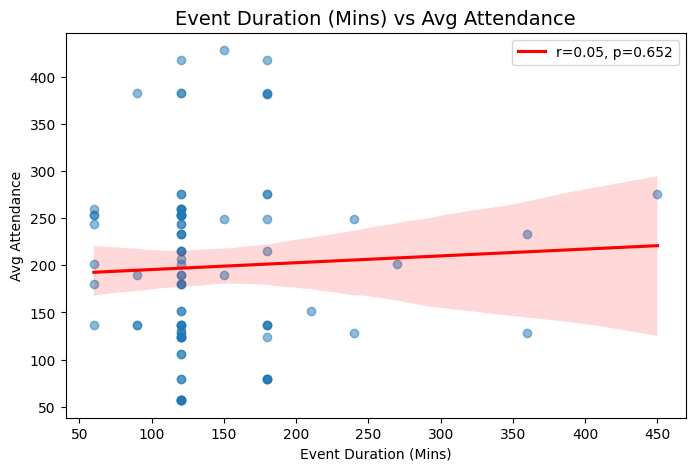

--- Ticket Price ($) vs Avg Attendance ---
Correlation: -0.0843 | P-Value: 3.4976e-01 (Not Significant)



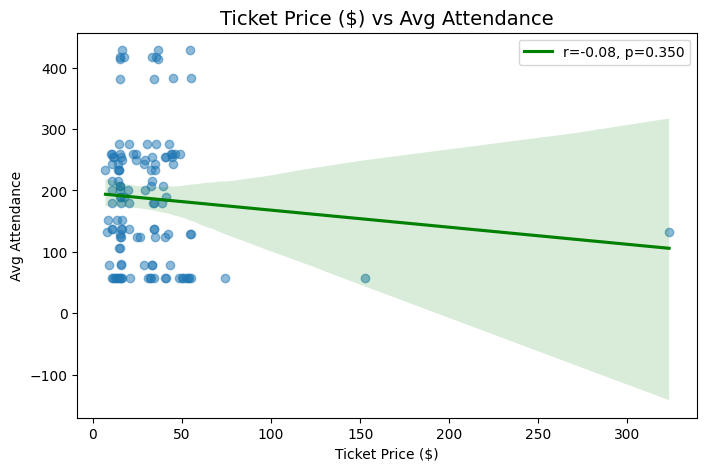

In [33]:
# Strategic Correlations with P-Values

def plot_corr_with_significance(df, x_col, y_col, x_label, y_label, color):
    df_clean = df[
        (df[x_col] > 0) &           
        (df[x_col].notna()) &       
        (df[y_col].notna())
    ]
    
    removed_count = len(df) - len(df_clean)

    # Calculate stats
    r, p = stats.pearsonr(df_clean[x_col], df_clean[y_col])
    sig = "Significant" if p < 0.05 else "Not Significant"
    
    print(f"--- {x_label} vs {y_label} ---")
    print(f"Correlation: {r:.4f} | P-Value: {p:.4e} ({sig})\n")
    
    # Plot
    plt.figure(figsize=(8, 5))
    sns.regplot(data=df_clean, x=x_col, y=y_col, 
                scatter_kws={'alpha':0.5}, 
                line_kws={'color': color, 'label': f'r={r:.2f}, p={p:.3f}'})
    plt.title(f'{x_label} vs {y_label}', fontsize=14)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# 1. Duration vs Attendance
plot_corr_with_significance(df_final_events, 'duration_mins', 'avg_att_per_event', 
                            'Event Duration (Mins)', 'Avg Attendance', 'red')

# 2. Ticket Price vs Attendance
plot_corr_with_significance(df_final_events, 'avg_ticket_price', 'avg_att_per_event', 
                            'Ticket Price ($)', 'Avg Attendance', 'green')

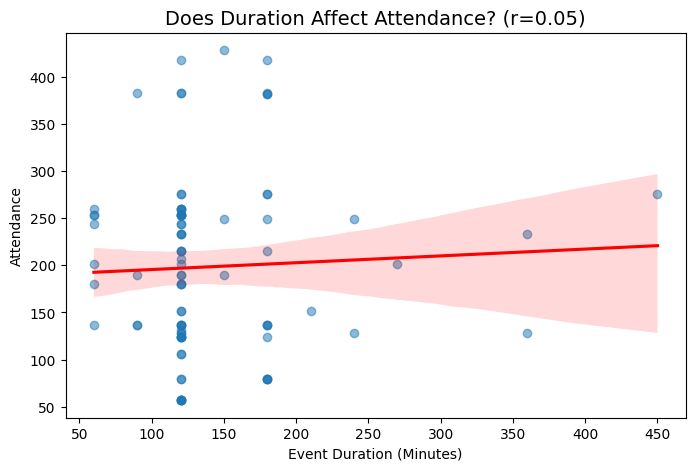

Correlation (Duration vs Attendance): 0.0478


In [34]:
# 1. Filter the null out
df_clean_duration = df_final_events[
    (df_final_events['duration_mins'] > 0) & 
    (df_final_events['duration_mins'].notna())
]

# 2. Duration vs Attendance
# Calculate the exact statistical correlation (r-value)
corr_duration = df_clean_duration['duration_mins'].corr(df_clean_duration['avg_att_per_event'])

plt.figure(figsize=(8, 5))
sns.regplot(data=df_clean_duration, x='duration_mins', y='avg_att_per_event', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title(f'Does Duration Affect Attendance? (r={corr_duration:.2f})', fontsize=14)
plt.xlabel('Event Duration (Minutes)')
plt.ylabel('Attendance')
plt.show()

print(f"Correlation (Duration vs Attendance): {corr_duration:.4f}")

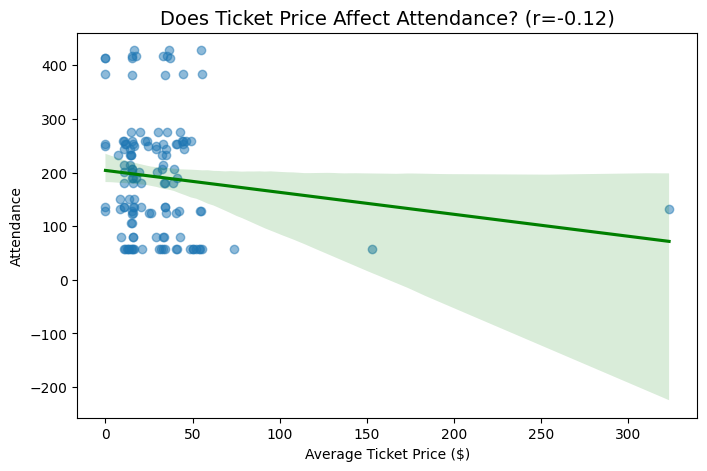

Correlation (Price vs Attendance): -0.1206


In [24]:
# 2. Ticket Price vs Attendance
corr_price = df_final_events['avg_ticket_price'].corr(df_final_events['avg_att_per_event'])

plt.figure(figsize=(8, 5))
sns.regplot(data=df_final_events, x='avg_ticket_price', y='avg_att_per_event', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
plt.title(f'Does Ticket Price Affect Attendance? (r={corr_price:.2f})', fontsize=14)
plt.xlabel('Average Ticket Price ($)')
plt.ylabel('Attendance')
plt.show()

print(f"Correlation (Price vs Attendance): {corr_price:.4f}")

# **Financial Health**

## Fetch Raw Data

In [25]:
# LOAD and PROCESS data from SQL


# 1. fetch raw data
sql_tickets = """
SELECT 
    DATE_FORMAT(date, '%%Y-%%m-01') AS month_key,
    SUM(ticket_prices) AS ticket_revenue
FROM tickets
WHERE ticket_prices IS NOT NULL 
  AND event_title NOT LIKE '%%ticket protection%%'
GROUP BY month_key;
"""

sql_donations = """
SELECT 
    DATE_FORMAT(date, '%%Y-%%m-01') AS month_key,
    SUM(donation_received) AS donation_revenue
FROM donations
GROUP BY month_key;
"""

sql_refunds = """
SELECT 
    DATE_FORMAT(date, '%%Y-%%m-01') AS month_key,
    SUM(credit_refunded) AS refund_amount
FROM credit_refunds
GROUP BY month_key;
"""

# Load DataFrames
df_tix_rev = run_query(sql_tickets)
df_don_rev = run_query(sql_donations)
df_ref_rev = run_query(sql_refunds)

# 2. merge the dataframes
df_finance = pd.merge(df_tix_rev, df_don_rev, on='month_key', how='outer')
df_finance = pd.merge(df_finance, df_ref_rev, on='month_key', how='outer')

# Fill NaNs with 0
df_finance = df_finance.fillna(0)

# 3. Net Revenue
df_finance['net_revenue'] = df_finance['ticket_revenue'] + df_finance['donation_revenue'] - df_finance['refund_amount']

# 4. Identify profit drivers
df_finance['primary_driver'] = np.where(
    df_finance['ticket_revenue'] > df_finance['donation_revenue'], 
    'Ticket-Driven', 
    'Donor-Driven'
)

# Convert month_key to datetime for plotting
df_finance['month_date'] = pd.to_datetime(df_finance['month_key'])

df_finance[['month_key', 'net_revenue', 'primary_driver']].head()

,month_key,net_revenue,primary_driver
0,2023-01-01,19038.0,Donor-Driven
1,2023-02-01,116321.0,Donor-Driven
2,2023-03-01,78849.0,Donor-Driven
3,2023-04-01,82157.0,Donor-Driven
4,2023-05-01,107420.0,Donor-Driven


## Visulization

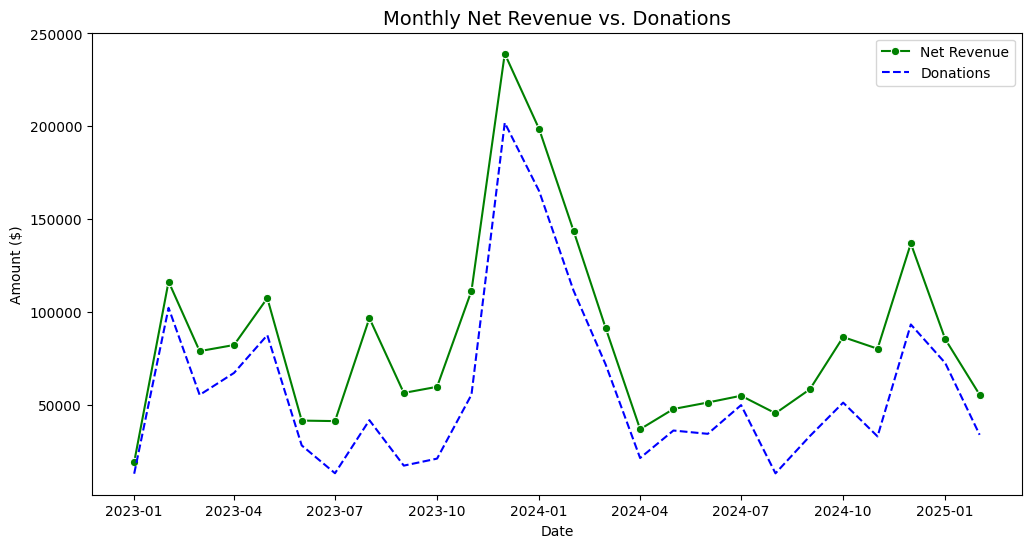

--- Top 5 Highest Revenue Months ---
Month: 2023-12-01 | Net: $239,066 | Key Events: A Celtic Christmas, The Nutcracker
Month: 2024-01-01 | Net: $198,499 | Key Events: FILM GEEK, Mike Birbiglia: Please Stop the Ride
Month: 2024-02-01 | Net: $143,674 | Key Events: Live2Lead Walla Walla, Caesar Sings Nat ‘King’ Cole
Month: 2024-12-01 | Net: $136,838 | Key Events: Rock the Holidays, A Celtic Christmas(1)
Month: 2023-02-01 | Net: $116,321 | Key Events: Youtopia (film), Scout Durwood Live


,month_key,ticket_revenue,donation_revenue,refund_amount,net_revenue,primary_driver,month_date
11,2023-12-01,37038.0,201861.0,-167.0,239066.0,Donor-Driven,2023-12-01
12,2024-01-01,32808.0,165035.0,-656.0,198499.0,Donor-Driven,2024-01-01
13,2024-02-01,31812.0,111474.0,-388.0,143674.0,Donor-Driven,2024-02-01
23,2024-12-01,43598.0,93213.0,-27.0,136838.0,Donor-Driven,2024-12-01
1,2023-02-01,14007.0,102186.0,-128.0,116321.0,Donor-Driven,2023-02-01


In [26]:
# 1. Net Revenue Trend Over Time
plt.figure(figsize=(12, 6))

# Plot Net Revenue
sns.lineplot(data=df_finance, x='month_date', y='net_revenue', color='green', label='Net Revenue', marker='o')

# Overlay Donations (to see the "Donor Driven" spikes)
sns.lineplot(data=df_finance, x='month_date', y='donation_revenue', color='blue', label='Donations', linestyle='--')

plt.title('Monthly Net Revenue vs. Donations', fontsize=14)
plt.ylabel('Amount ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

# 2. Top 5 Best Financial Months with events
top_months = df_finance.sort_values('net_revenue', ascending=False).head(5)
top_profit_months = pd.DataFrame(top_months)

print("--- Top 5 Highest Revenue Months ---")
for index, row in top_profit_months.iterrows():
    m_key = row['month_key']
    rev = row['net_revenue']

    events_in_month = df_final_events[df_final_events['month_key'] == m_key]['event_title'].unique()
    event_str = ", ".join(events_in_month[:2]) # List top 2 events
    print(f"Month: {m_key} | Net: ${rev:,.0f} | Key Events: {event_str}")
top_profit_months

## Seasonality and Impact Analysis

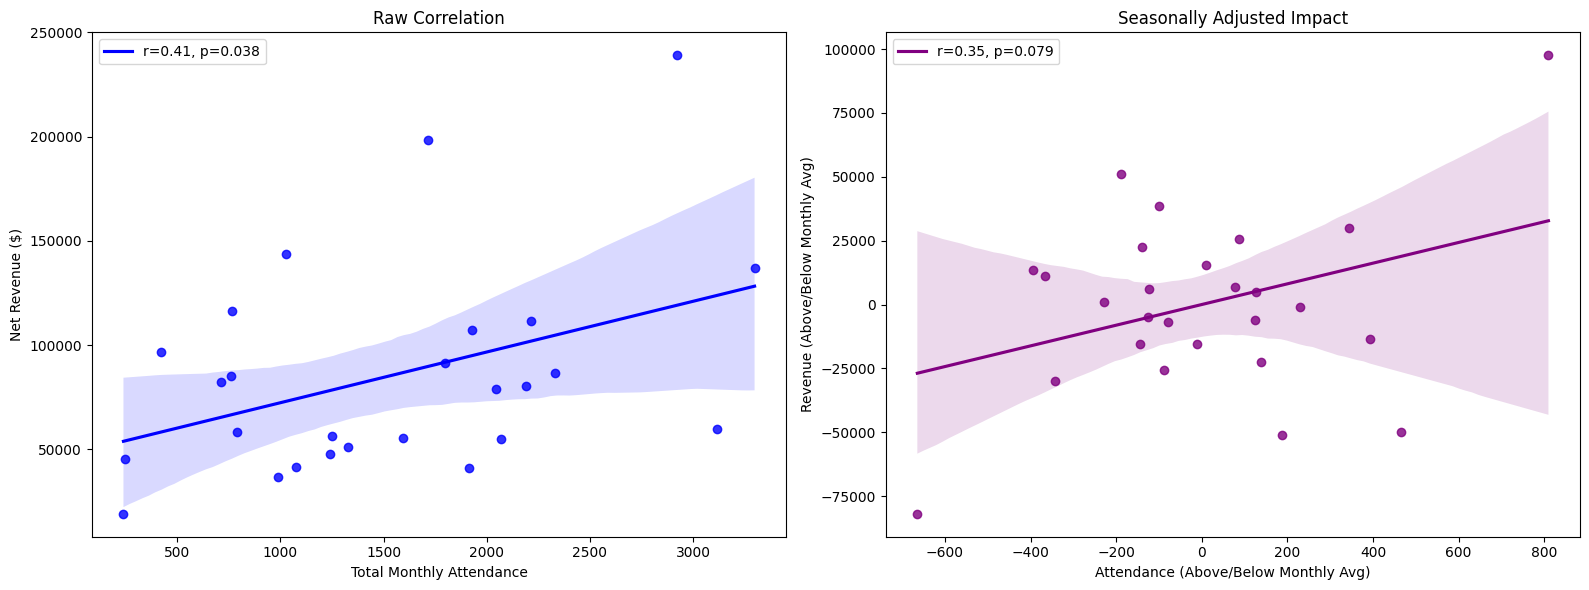

Significance Test Results
1. Raw Correlation:      r=0.4090 | p=3.8027e-02 (Significant)
2. Seasonally Adjusted:  r=0.3509 | p=7.8798e-02 (Not Sig)


In [36]:
# 1. Prepare the data
# Merge Financials with Attendance
df_impact = pd.merge(df_finance, df_att_monthly, on='month_key', how='inner')

# Create Month Number for grouping (1=Jan, 2=Feb, etc.)
df_impact['month_num'] = pd.to_datetime(df_impact['month_key']).dt.month

# 2. calculate seasonal residuals

monthly_means = df_impact.groupby('month_num')[['total_attendance', 'net_revenue']].transform('mean')

# Calculate Residuals (Actual - Monthly Average)
df_impact['att_resid'] = df_impact['total_attendance'] - monthly_means['total_attendance']
df_impact['rev_resid'] = df_impact['net_revenue'] - monthly_means['net_revenue']

# 3. statistical tests
# Raw Correlation (Does higher attendance = higher revenue?)
r_raw, p_raw = stats.pearsonr(df_impact['total_attendance'], df_impact['net_revenue'])

# Adjusted Correlation (Does "beating expectations" = higher revenue?)
df_clean = df_impact.dropna(subset=['att_resid', 'rev_resid'])
r_adj, p_adj = stats.pearsonr(df_clean['att_resid'], df_clean['rev_resid'])

# 4. visalization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw Correlation
sns.regplot(data=df_impact, x='total_attendance', y='net_revenue', ax=axes[0], color='blue', line_kws={'label': f'r={r_raw:.2f}, p={p_raw:.3f}'})
axes[0].set_title(f'Raw Correlation')
axes[0].set_xlabel('Total Monthly Attendance')
axes[0].set_ylabel('Net Revenue ($)')
axes[0].legend()

# Seasonally Adjusted
sns.regplot(data=df_impact, x='att_resid', y='rev_resid', ax=axes[1], color='purple', line_kws={'label': f'r={r_adj:.2f}, p={p_adj:.3f}'})
axes[1].set_title(f'Seasonally Adjusted Impact')
axes[1].set_xlabel('Attendance (Above/Below Monthly Avg)')
axes[1].set_ylabel('Revenue (Above/Below Monthly Avg)')
axes[1].legend()

plt.tight_layout()
plt.show()

# 5. intepretation
print(f"Significance Test Results")
print(f"1. Raw Correlation:      r={r_raw:.4f} | p={p_raw:.4e} ({'Significant' if p_raw<0.05 else 'Not Sig'})")
print(f"2. Seasonally Adjusted:  r={r_adj:.4f} | p={p_adj:.4e} ({'Significant' if p_adj<0.05 else 'Not Sig'})")

## Genre Type Impact on Finance

In [28]:
# 1. Prepare the data
# Pivot to get counts of each genre per month
monthly_genre_counts = pd.crosstab(df_final_events['month_key'], df_final_events['genre']).reset_index()

# Merge Financials (Net Revenue) + Attendance + Genre Counts
df_model_data = pd.merge(df_finance[['month_key', 'net_revenue']], df_att_monthly, on='month_key', how='inner')
df_model_data = pd.merge(df_model_data, monthly_genre_counts, on='month_key', how='inner')

# Target : Net Revenue 
y = df_model_data['net_revenue']

# Predictors (X): Total Attendance + The Count of Each Genre
# We want to see: Does the Genre matter *after* we account for the raw number of people?
genre_cols = [c for c in monthly_genre_counts.columns if c != 'month_key']
X = df_model_data[['total_attendance'] + genre_cols]

# Add a constant (intercept)
X = sm.add_constant(X)

# 3. Run the regression (OLS)
model_finance = sm.OLS(y, X).fit()

# 4. interpretation
print(model_finance.summary())

print("\n--- CFO'S SUMMARY ---")
base_val = model_finance.params['const']
att_val = model_finance.params['total_attendance']
print(f"Baseline Monthly Revenue: ${base_val:,.2f}")
print(f"Value of 1 Additional Attendee: ${att_val:.2f}")

print("\n--- Genre 'Premium' (Impact beyond just ticket sales) ---")
for genre in genre_cols:
    coef = model_finance.params[genre]
    p_val = model_finance.pvalues[genre]
    
    # Logic to make the output readable
    sig_label = " Significant" if p_val < 0.1 else "Not Significant"
    
    print(f"- Scheduling a '{genre}': ${coef:,.0f} impact ({sig_label})")

                            OLS Regression Results                            
Dep. Variable:            net_revenue   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                 -0.099
Method:                 Least Squares   F-statistic:                    0.7185
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.673
Time:                        13:52:08   Log-Likelihood:                -314.16
No. Observations:                  26   AIC:                             646.3
Df Residuals:                      17   BIC:                             657.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.197e+04    2.5e+0